In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pandas as pd

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set compatibility mode
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set pandas display option
pd.options.display.float_format = "{:,.4f}".format 

# RTX ON
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [4]:
NUM_FEATURES = 21
NUM_CLASSES = 3

hidden_units = 10
learning_rate = 0.01
beta = 10**-6
batch_size = [4, 8, 16, 32, 64]
no_folds = 5

epochs = 2000
seed = 10
np.random.seed(seed)

In [5]:
# Read data
data_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
data_X, data_Y = data_input[1:, :21], data_input[1:,-1].astype(int)
dataX = scale(data_X, np.min(data_X, axis=0), np.max(data_X, axis=0)) #Scaled X

# Define the size of training set and data set
dataset_size = len(dataX)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size

# Shuffle the data before splitting to train test set
# Data of the same class are usually cluster together in the dataset, we want to shuffle them
idx = np.arange(dataset_size)
np.random.shuffle(idx)
dataX = dataX[idx]
data_Y = data_Y[idx]
dataY = np.zeros((data_Y.shape[0], NUM_CLASSES))
dataY[np.arange(data_Y.shape[0]), data_Y-1] = 1 #one hot matrix

# Split the training and testing set
trainX = dataX[:train_size]
trainY = dataY[:train_size]

testX = dataX[train_size:]
testY = dataY[train_size:]

In [6]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Build the graph for the neural network
# Hidden layer with relu activation
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, hidden_units], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
b1 = tf.Variable(tf.zeros([hidden_units]),name='biases')
h1 = tf.nn.relu(tf.matmul(x, w1) + b1) 

w2 = tf.Variable(tf.truncated_normal([hidden_units, NUM_CLASSES], stddev=1.0/math.sqrt(float(hidden_units))), name='weights')
b2 = tf.Variable(tf.zeros([NUM_CLASSES]),name='biases')
u = tf.matmul(h1, w2) + b2  #logits=u
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=u)

In [7]:
# Regularization
regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)

# Regularized loss
loss = tf.reduce_mean(cross_entropy + beta*regularization)

In [8]:
# Define the optimiser
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

# Create a variable to track the global step
global_step = tf.Variable(0, name='global_step', trainable=False)

# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
train_op = optimizer.minimize(loss, global_step=global_step)

In [9]:
# Evaluate the accuracy and error
correct_prediction = tf.cast(tf.equal(tf.argmax(u, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
error = tf.reduce_sum(tf.cast(tf.not_equal(tf.argmax(u, axis=1), tf.argmax(y_, axis=1)), dtype=tf.int32))

[batch 4 fold 1 iteration 1] validation accuracy: 0.7946127653121948
[batch 4 fold 1 iteration 1000] validation accuracy: 0.9023569226264954
[batch 4 fold 1 iteration 2000] validation accuracy: 0.9191918969154358

[batch 4 fold 2 iteration 1] validation accuracy: 0.7575757503509521
[batch 4 fold 2 iteration 1000] validation accuracy: 0.9124578833580017
[batch 4 fold 2 iteration 2000] validation accuracy: 0.9158248901367188

[batch 4 fold 3 iteration 1] validation accuracy: 0.7979797720909119
[batch 4 fold 3 iteration 1000] validation accuracy: 0.9158248901367188
[batch 4 fold 3 iteration 2000] validation accuracy: 0.9191918969154358

[batch 4 fold 4 iteration 1] validation accuracy: 0.744107723236084
[batch 4 fold 4 iteration 1000] validation accuracy: 0.872053861618042
[batch 4 fold 4 iteration 2000] validation accuracy: 0.875420868396759

[batch 4 fold 5 iteration 1] validation accuracy: 0.7845118045806885
[batch 4 fold 5 iteration 1000] validation accuracy: 0.9158248901367188
[batch

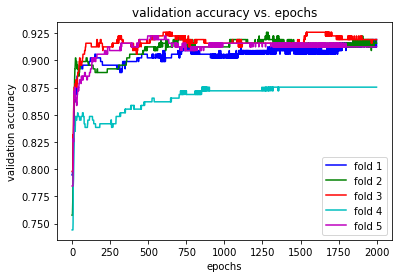

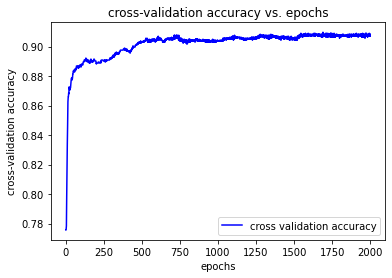

For batch 4, end validation accuracy for each fold: [0.9191919, 0.9158249, 0.9191919, 0.87542087, 0.9124579]
cross validation accuracy 0.9084174036979675

[batch 8 fold 1 iteration 1] validation accuracy: 0.7946127653121948
[batch 8 fold 1 iteration 1000] validation accuracy: 0.8956229090690613
[batch 8 fold 1 iteration 2000] validation accuracy: 0.8956229090690613

[batch 8 fold 2 iteration 1] validation accuracy: 0.7575757503509521
[batch 8 fold 2 iteration 1000] validation accuracy: 0.8922559022903442
[batch 8 fold 2 iteration 2000] validation accuracy: 0.9023569226264954

[batch 8 fold 3 iteration 1] validation accuracy: 0.7979797720909119
[batch 8 fold 3 iteration 1000] validation accuracy: 0.9225589036941528
[batch 8 fold 3 iteration 2000] validation accuracy: 0.936026930809021

[batch 8 fold 4 iteration 1] validation accuracy: 0.744107723236084
[batch 8 fold 4 iteration 1000] validation accuracy: 0.8619528412818909
[batch 8 fold 4 iteration 2000] validation accuracy: 0.878787875

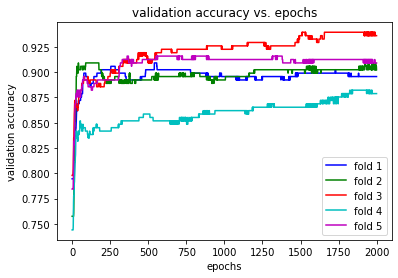

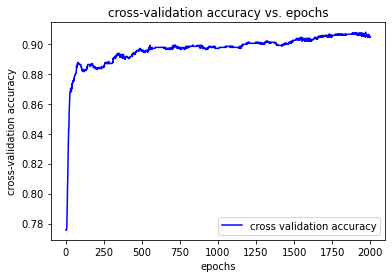

For batch 8, end validation accuracy for each fold: [0.8956229, 0.9023569, 0.93602693, 0.8787879, 0.90909094]
cross validation accuracy 0.9043771624565125

[batch 16 fold 1 iteration 1] validation accuracy: 0.7946127653121948
[batch 16 fold 1 iteration 1000] validation accuracy: 0.8821548819541931
[batch 16 fold 1 iteration 2000] validation accuracy: 0.9023569226264954

[batch 16 fold 2 iteration 1] validation accuracy: 0.7575757503509521
[batch 16 fold 2 iteration 1000] validation accuracy: 0.9023569226264954
[batch 16 fold 2 iteration 2000] validation accuracy: 0.9023569226264954

[batch 16 fold 3 iteration 1] validation accuracy: 0.7979797720909119
[batch 16 fold 3 iteration 1000] validation accuracy: 0.9124578833580017
[batch 16 fold 3 iteration 2000] validation accuracy: 0.9225589036941528

[batch 16 fold 4 iteration 1] validation accuracy: 0.747474730014801
[batch 16 fold 4 iteration 1000] validation accuracy: 0.8518518805503845
[batch 16 fold 4 iteration 2000] validation accurac

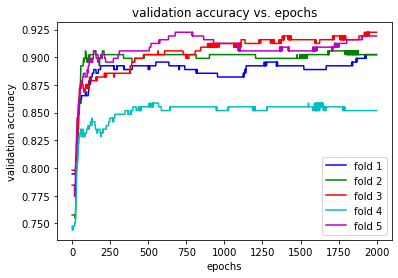

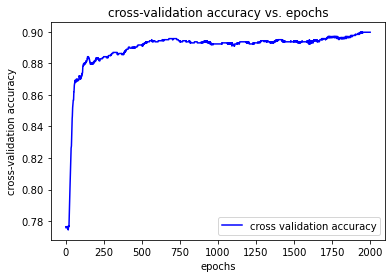

For batch 16, end validation accuracy for each fold: [0.9023569, 0.9023569, 0.9225589, 0.8518519, 0.9191919]
cross validation accuracy 0.8996633291244507

[batch 32 fold 1 iteration 1] validation accuracy: 0.7946127653121948
[batch 32 fold 1 iteration 1000] validation accuracy: 0.9057239294052124
[batch 32 fold 1 iteration 2000] validation accuracy: 0.8922559022903442

[batch 32 fold 2 iteration 1] validation accuracy: 0.7575757503509521
[batch 32 fold 2 iteration 1000] validation accuracy: 0.9023569226264954
[batch 32 fold 2 iteration 2000] validation accuracy: 0.8922559022903442

[batch 32 fold 3 iteration 1] validation accuracy: 0.7878788113594055
[batch 32 fold 3 iteration 1000] validation accuracy: 0.9090909361839294
[batch 32 fold 3 iteration 2000] validation accuracy: 0.9124578833580017

[batch 32 fold 4 iteration 1] validation accuracy: 0.744107723236084
[batch 32 fold 4 iteration 1000] validation accuracy: 0.8383838534355164
[batch 32 fold 4 iteration 2000] validation accuracy

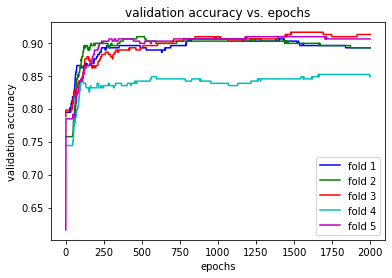

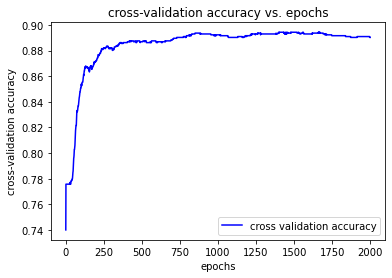

For batch 32, end validation accuracy for each fold: [0.8922559, 0.8922559, 0.9124579, 0.8484849, 0.9057239]
cross validation accuracy 0.8902357220649719

[batch 64 fold 1 iteration 1] validation accuracy: 0.6565656661987305
[batch 64 fold 1 iteration 1000] validation accuracy: 0.8956229090690613
[batch 64 fold 1 iteration 2000] validation accuracy: 0.9057239294052124

[batch 64 fold 2 iteration 1] validation accuracy: 0.7575757503509521
[batch 64 fold 2 iteration 1000] validation accuracy: 0.9090909361839294
[batch 64 fold 2 iteration 2000] validation accuracy: 0.8956229090690613

[batch 64 fold 3 iteration 1] validation accuracy: 0.5454545617103577
[batch 64 fold 3 iteration 1000] validation accuracy: 0.8821548819541931
[batch 64 fold 3 iteration 2000] validation accuracy: 0.9090909361839294

[batch 64 fold 4 iteration 1] validation accuracy: 0.7575757503509521
[batch 64 fold 4 iteration 1000] validation accuracy: 0.8350168466567993
[batch 64 fold 4 iteration 2000] validation accurac

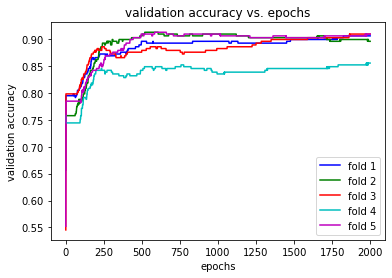

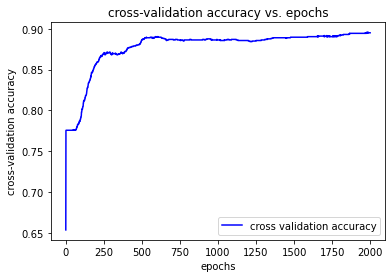

For batch 64, end validation accuracy for each fold: [0.9057239, 0.8956229, 0.90909094, 0.8552188, 0.90909094]
cross validation accuracy 0.8949495553970337

cross validation accuracy for each batch: [0.9084174, 0.90437716, 0.8996633, 0.8902357, 0.89494956]


In [10]:
N = train_size #70% of the dataset
Nf = N//no_folds

cross_validation_acc =[]
x_validation_acc = np.zeros((no_folds, epochs))

for batch in batch_size:

    validation_acc = np.zeros(no_folds*epochs).reshape(no_folds, epochs)
    ending_validation_acc = []


    for fold in range(no_folds):

        startingIndex , endingIndex = fold*Nf, (fold+1)*Nf
        # Dataset is divided to 70:30 ratio for training and testing
        # The 70%  will go through the 5-fold cross validation
        # For each round, 4 folds will be use for training and 1 fold will be used for validation
        trainX_validate , trainY_validate = trainX[startingIndex:endingIndex], trainY[startingIndex:endingIndex]
        trainX_train = np.append(trainX[:startingIndex],trainX[endingIndex:],axis=0)
        trainY_train = np.append(trainY[:startingIndex],trainY[endingIndex:],axis=0)

        # Run the session
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epochs):

                for start, end in zip(range(0, N, batch), range(batch, N, batch)): #Want to use all trainX dataset
                    train_op.run(feed_dict={x: trainX_train[start:end], y_: trainY_train[start:end]})

                # Calculate validation acc and record it for graph plotting with against epochs
                validation_acc[fold][i]= accuracy.eval(feed_dict={x: trainX_validate, y_: trainY_validate})
                if i == 0 or (i+1)%1000 == 0:
                    print('[batch {} fold {} iteration {}] validation accuracy: {}'.format(batch, fold+1 ,i+1, validation_acc[fold][i]))

            print('')

            #Final validation accuracy at end of epochs
            ending_validation_acc.append(accuracy.eval(feed_dict={x: trainX_validate, y_: trainY_validate}))

    # Plot learning curves

    plt.figure()
    plt.title('validation accuracy vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('validation accuracy')
    plt.plot(range(epochs), validation_acc[0],'b',label='fold 1')
    plt.plot(range(epochs), validation_acc[1],'g',label='fold 2')
    plt.plot(range(epochs), validation_acc[2],'r',label='fold 3')
    plt.plot(range(epochs), validation_acc[3],'c',label='fold 4')
    plt.plot(range(epochs), validation_acc[4],'m',label='fold 5')
    plt.legend(loc='best')
    plt.show()  
    
    plt.figure()
    plt.title('cross-validation accuracy vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('cross-validation accuracy')
    plt.plot(range(epochs), np.mean(validation_acc, axis=0) ,'b',label='cross validation accuracy')
    plt.legend(loc='best')
    plt.show()
    
    if batch == 4:
        x_validation_acc[0] = np.mean(validation_acc, axis=0)
    elif batch == 8:
        x_validation_acc[1] = np.mean(validation_acc, axis=0)
    elif batch == 16:
        x_validation_acc[2] = np.mean(validation_acc, axis=0)
    elif batch == 32:
        x_validation_acc[3] = np.mean(validation_acc, axis=0)
    elif batch == 64:
        x_validation_acc[4] = np.mean(validation_acc, axis=0)
    
    print("For batch {}, end validation accuracy for each fold: {}".format(batch, ending_validation_acc))
    cv_acc = np.mean(np.array(ending_validation_acc), axis = 0)
    print("cross validation accuracy {}".format(cv_acc))
    cross_validation_acc.append(cv_acc)
    print()

print("cross validation accuracy for each batch: {}".format(cross_validation_acc))

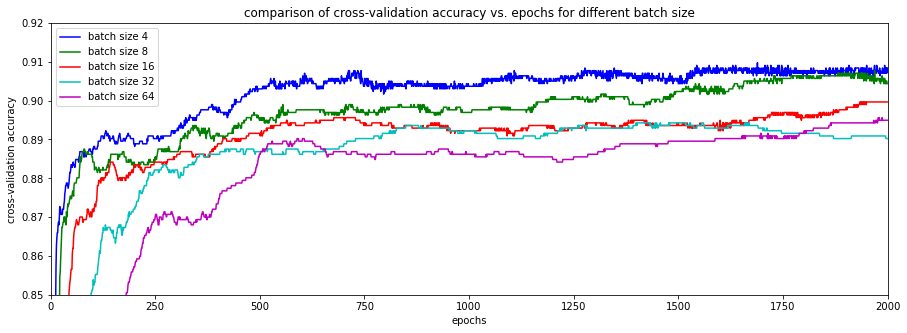

In [11]:
plt.figure(figsize=(15,5))
plt.title('comparison of cross-validation accuracy vs. epochs for different batch sizes')
plt.xlabel('epochs')
plt.ylabel('cross-validation accuracy')
plt.xlim(0,2000)
plt.ylim(0.85,0.92)
plt.plot(range(epochs), x_validation_acc[0],'b',label='batch size 4')
plt.plot(range(epochs), x_validation_acc[1],'g',label='batch size 8')
plt.plot(range(epochs), x_validation_acc[2],'r',label='batch size 16')
plt.plot(range(epochs), x_validation_acc[3],'c',label='batch size 32')
plt.plot(range(epochs), x_validation_acc[4],'m',label='batch size 64')
plt.legend(loc='best')
plt.show()

In [24]:
batch_size = [4, 8, 16, 32, 64]

In [25]:
#For simplicity, we will not consider the 5-fold

import time

N = train_size
time_taken=[]

for batch in batch_size:
  
    time_to_update = 0
  
  #Running the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())      
    
        for i in range(epochs): #set epoch to be 1
            t = time.time()     
            for start, end in zip(range(0, N, batch), range(batch, N, batch)): 
                train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})      
        time_to_update += time.time()-t
      
    time_taken.append((time_to_update*1e3)/(epochs*(N//batch)))

In [26]:
print("For the batch in batch size:", batch_size)
print("The respective time taken to update the batch:",time_taken)

For the batch in batch size: [4, 8, 16, 32, 64]
The respective time taken to update the batch: [0.000546923888626919, 0.0005147508395615444, 0.00047185344080771167, 0.0004553043324014415, 0.00043361601622208303]


In [27]:
df = pd.DataFrame()
df['Batch Size'] = batch_size
df['Time Taken'] = time_taken
df

,Batch Size,Time Taken
0,4,0.0005
1,8,0.0005
2,16,0.0005
3,32,0.0005
4,64,0.0004


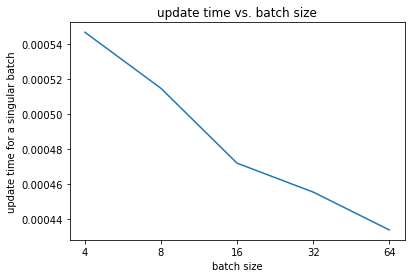

In [28]:
plt.figure()
plt.plot(range(len(batch_size)), time_taken)
plt.xticks(range(len(batch_size)), batch_size)
plt.xlabel('batch size')
plt.ylabel('update time for a singular batch')
plt.title('update time vs. batch size')
plt.show()

In [30]:
N = train_size
time_taken_np = np.asarray(time_taken)
batch_size_np = np.asarray(batch_size)
time_taken_to_train_network= N/batch_size_np*time_taken_np


df = pd.DataFrame()
df['Batch Size'] = batch_size
df['Time Taken'] = time_taken_to_train_network
df

,Batch Size,Time Taken
0,4,0.2035
1,8,0.0957
2,16,0.0439
3,32,0.0212
4,64,0.0101


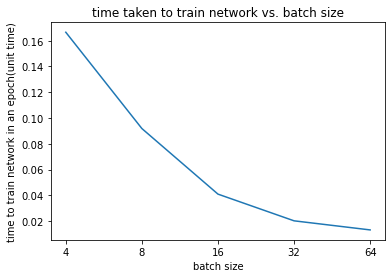

In [16]:
plt.figure()
plt.plot(range(len(batch_size)), time_taken_to_train_network)
plt.xticks(range(len(batch_size)), batch_size)
plt.xlabel('batch size')
plt.ylabel('time to train network in an epoch(unit time)')
plt.title('time taken to train network vs. batch size')
plt.show()

In [17]:
batch_size = 16

N = train_size

#Running the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    train_acc = []
    test_acc =[]
  
    for i in range(epochs):
    
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
    
        train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))       
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
    
        if i == 0 or (i+1)%1000 == 0:
            print('[Iteration {}]'.format(i+1))
            print('⏵train accuracy: {}'.format(i+1, train_acc[i]))
            print('⏵test accuracy:  {}'.format(i+1, test_acc[i]))
            print()

[Iteration 1]
⏵train accuracy: 1
⏵test accuracy:  1

[Iteration 1000]
⏵train accuracy: 1000
⏵test accuracy:  1000

[Iteration 2000]
⏵train accuracy: 2000
⏵test accuracy:  2000



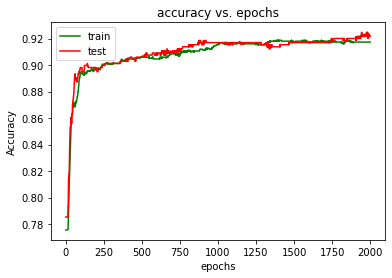

In [18]:
# plot learning curves
plt.figure()
plt.title('accuracy vs. epochs')
plt.plot(range(epochs), train_acc,'g',label='train')
plt.plot(range(epochs), test_acc,'r',label='test')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()